In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install xlrd

In [3]:
df = pd.read_csv("arrests_procesado_ST.csv")

In [4]:
df.head()

,ID,Date,PD_CD,PD_DESC,KY_CD,Description,Law,Precint,X_COORD_CD,Y_COORD_CD,...,Sex_M,Race_ASIAN / PACIFIC ISLANDER,Race_BLACK,Race_BLACK HISPANIC,Race_OTHER,Race_WHITE,Race_WHITE HISPANIC,day_of_year,sin_day,cos_day
0,85594383,2012-07-05,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,NaN,25,1003300.0,5230799.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,187,-0.077386,-0.997001
1,84747924,2012-05-15,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,NaN,40,1007098.0,3234465.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,136,0.717677,-0.696376
2,84164045,2012-04-11,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,NaN,47,1027676.0,2261851.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,102,0.982927,-0.183998
3,82437256,2012-01-02,397.0,"ROBBERY,UNCLASSIFIED,OPEN AREAS",105.0,ROBBERY,NaN,52,1013626.0,3253434.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0.034422,0.999407
4,82300383,2011-12-22,782.0,"WEAPONS, POSSESSION, ETC",236.0,DANGEROUS WEAPONS,NaN,47,1027676.0,2261851.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,356,-0.154309,0.988023


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5299706 entries, 0 to 5299705
Data columns (total 65 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ID                             int64  
 1   Date                           object 
 2   PD_CD                          float64
 3   PD_DESC                        object 
 4   KY_CD                          float64
 5   Description                    object 
 6   Law                            float64
 7   Precint                        int64  
 8   X_COORD_CD                     float64
 9   Y_COORD_CD                     float64
 10  Latitude                       float64
 11  Longitude                      float64
 12  Lon_Lat                        object 
 13  Month                          float64
 14  Day                            float64
 15  Category_Infraction            float64
 16  Category_Misdemeanor           float64
 17  Category_Unknown               float64
 18  Ca

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

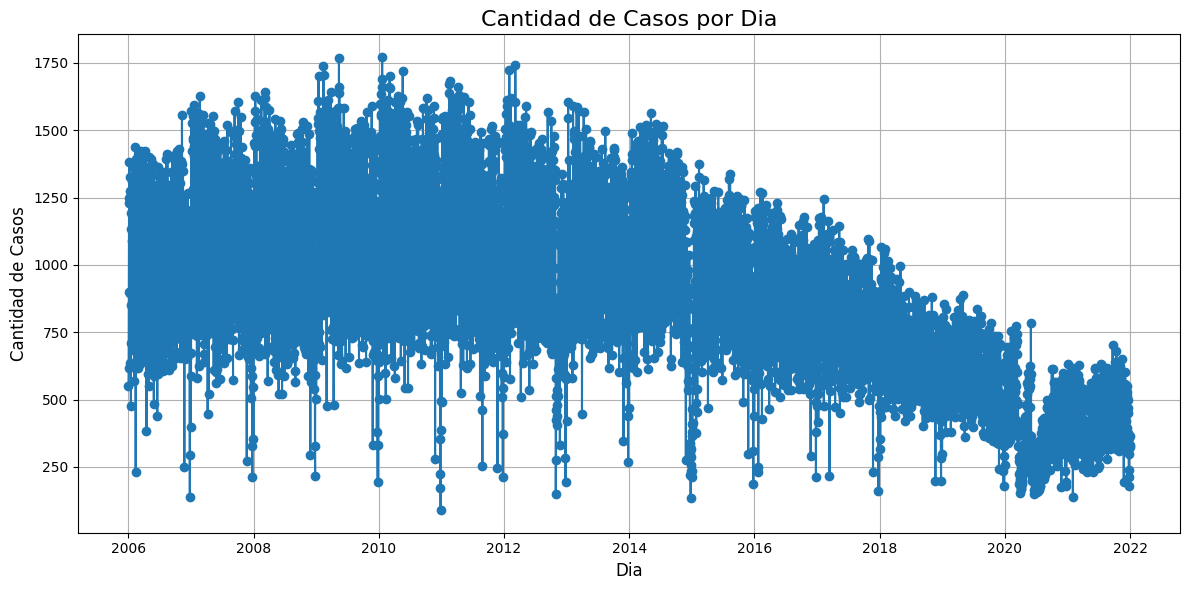

In [7]:
df_dia = df.groupby(df['Date'].dt.to_period('D')).size().reset_index(name='CASE_COUNT')

# Convierte la columna de periodos a datetime para ordenar correctamente
df_dia['Date'] = df_dia['Date'].dt.to_timestamp()

# Visualiza los datos en un gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_dia['Date'], df_dia['CASE_COUNT'], marker='o', linestyle='-')
plt.title('Cantidad de Casos por Dia', fontsize=16)
plt.xlabel('Dia', fontsize=12)
plt.ylabel('Cantidad de Casos', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df_dia = df_dia.set_index('Date')
y = df_dia['CASE_COUNT'].resample('MS').sum() # Para ver la descomposicion mensualmente

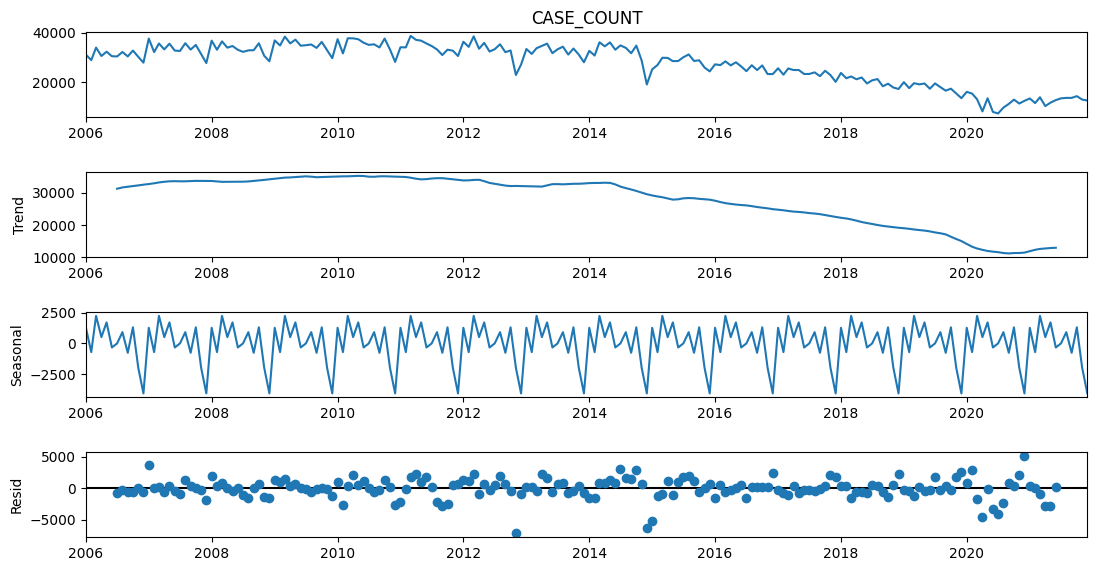

In [9]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 6)

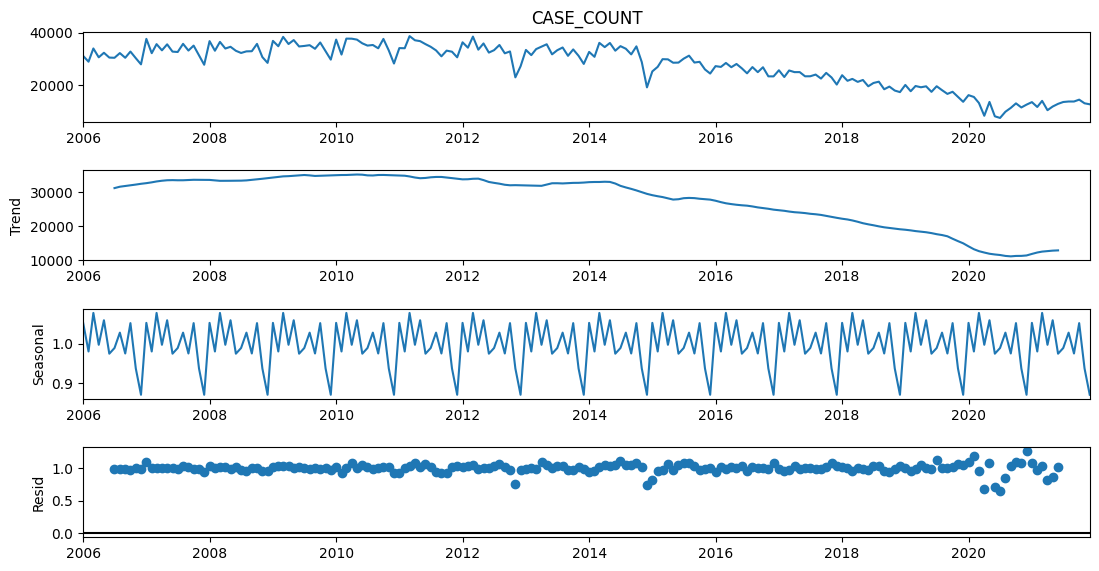

In [10]:
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(12, 6)

### Random Walk

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_dia, test_size=0.2, shuffle=False, random_state=42)

In [12]:
df_train.tail()

,CASE_COUNT
Date,
2018-10-15,558
2018-10-16,733
2018-10-17,814
2018-10-18,677
2018-10-19,661


In [13]:
df_train['CASE_COUNT_SHIFT1'] = df_train.CASE_COUNT.shift()

df_train['CASE_COUNT_SHIFT1'].fillna(method='bfill', inplace=True)
df_train.head()

,CASE_COUNT,CASE_COUNT_SHIFT1
Date,,
2006-01-01,551,551.0
2006-01-02,618,551.0
2006-01-03,899,618.0
2006-01-04,1229,899.0
2006-01-05,1383,1229.0


<Axes: xlabel='Date'>

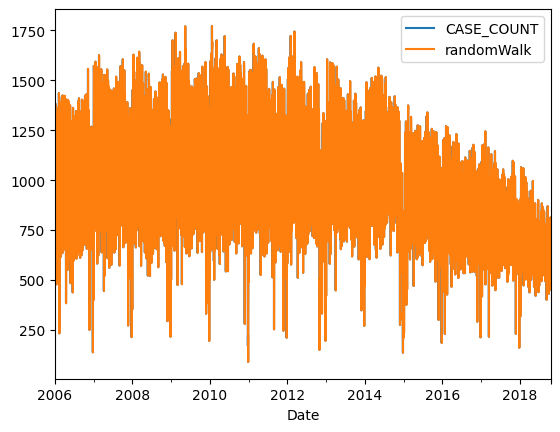

In [14]:
df_train['randomWalk'] = df_train.CASE_COUNT_SHIFT1
df_train.plot(kind='line', y=['CASE_COUNT', 'randomWalk'])

<Axes: xlabel='Date'>

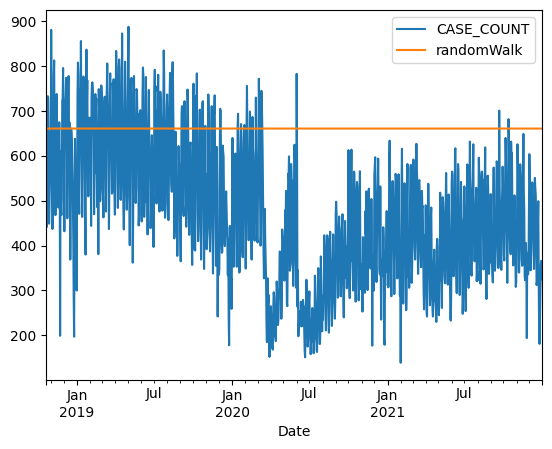

In [15]:
df_test['randomWalk'] = pd.Series(df_train['CASE_COUNT'][-1], index=df_test.index)
df_test.plot(kind='line', y=['CASE_COUNT', 'randomWalk'])

In [16]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [17]:
df_results = pd.DataFrame(columns = ["Model", "RMSE"])
df_results.loc[0, "Model"] = "Random Walk"
df_results.loc[0, "RMSE"] = RMSE(df_test.randomWalk, df_test.CASE_COUNT)
df_results

,Model,RMSE
0,Random Walk,244.370694


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4675 entries, 2006-01-01 to 2018-10-19
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CASE_COUNT         4675 non-null   int64  
 1   CASE_COUNT_SHIFT1  4675 non-null   float64
 2   randomWalk         4675 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 146.1 KB


In [19]:
model_mean_pred = df_train['CASE_COUNT'].mean()
model_mean_pred

1015.4203208556149

In [20]:
df_train_mc = df_train.copy()
df_train_mc['Mean'] = model_mean_pred

df_test_mc = df_test.copy()
df_test_mc['Mean'] = model_mean_pred

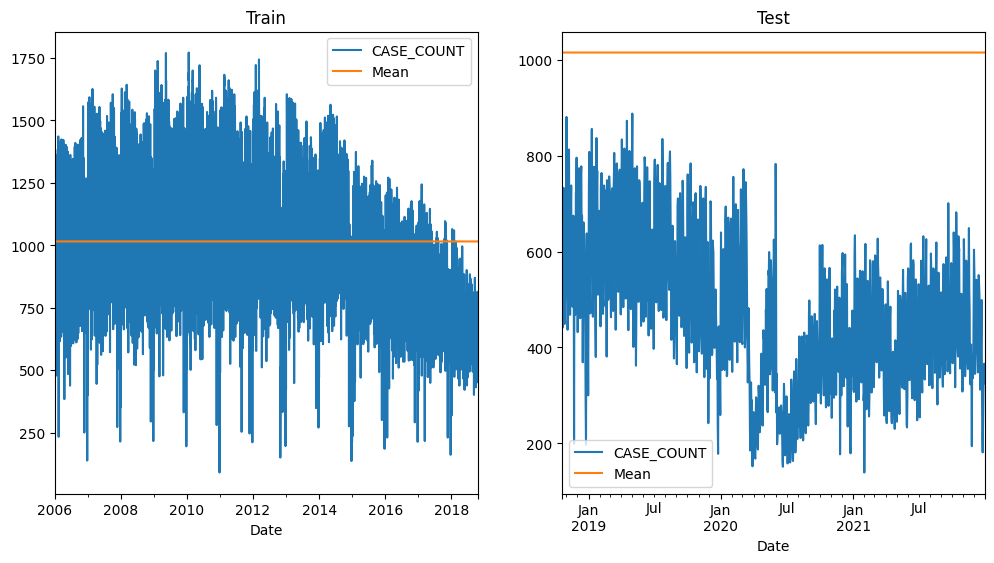

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df_train_mc.plot(ax=axes[0], y = ["CASE_COUNT","Mean"],title='Train')
df_test_mc.plot(ax=axes[1],y = ["CASE_COUNT","Mean"], title='Test')
plt.show()

In [22]:
model_rmse = RMSE(df_test_mc.Mean, df_test_mc.CASE_COUNT)

In [23]:
df_results.loc[1, "Model"] = "Mean"
df_results.loc[1, "RMSE"] = model_rmse
df_results.head()

,Model,RMSE
0,Random Walk,244.370694
1,Mean,564.612685


## Tendencial Lineal

In [24]:
df_dia['timeIndex'] = pd.Series(np.arange(len(df_dia['CASE_COUNT'])), index=df_dia.index)
df_dia.timeIndex.head()

Date
2006-01-01    0
2006-01-02    1
2006-01-03    2
2006-01-04    3
2006-01-05    4
Name: timeIndex, dtype: int32

In [25]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_dia, test_size=0.2, shuffle=False, random_state=42)

In [26]:
import statsmodels.formula.api as smf
model_linear = smf.ols(formula='CASE_COUNT ~ timeIndex', data=df_train).fit()

In [27]:
df_train['LinearTrend'] = model_linear.predict(df_train.timeIndex)
df_test['LinearTrend'] = model_linear.predict(df_test.timeIndex)

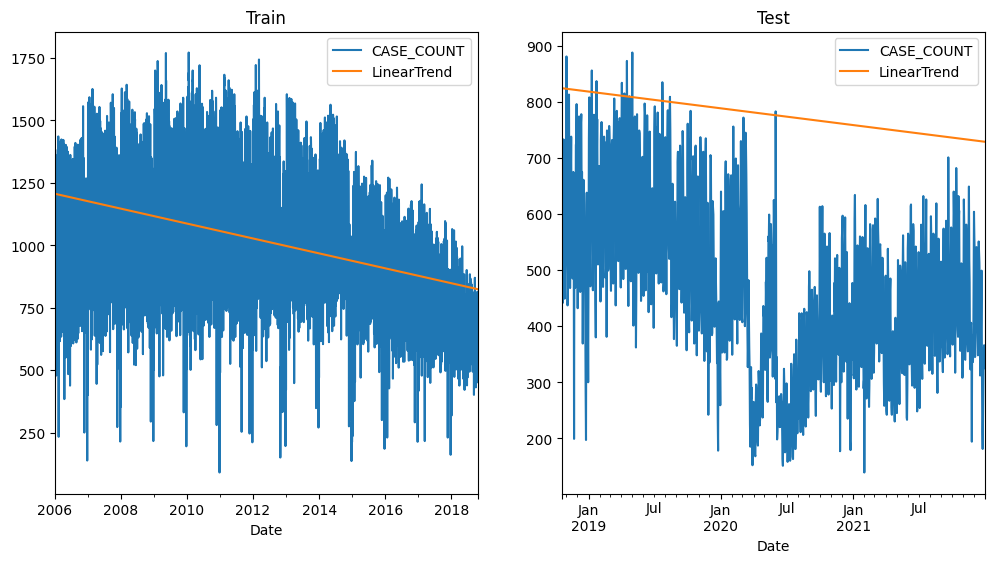

In [28]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
df_train.plot(kind="line", y = ["CASE_COUNT", "LinearTrend"], ax=axes[0], title='Train')
df_test.plot(kind="line", y = ["CASE_COUNT", "LinearTrend"], ax=axes[1], title='Test')
plt.show()

In [29]:
model_rmse = RMSE(df_test.LinearTrend, df_test.CASE_COUNT)

In [30]:
df_results.loc[2, "Model"] = "Linear Trend"
df_results.loc[2, "RMSE"] = model_rmse
df_results.head()

,Model,RMSE
0,Random Walk,244.370694
1,Mean,564.612685
2,Linear Trend,336.575295


In [31]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CASE_COUNT   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     725.8
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          9.93e-149
Time:                        13:36:38   Log-Likelihood:                -32974.
No. Observations:                4675   AIC:                         6.595e+04
Df Residuals:                    4673   BIC:                         6.596e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1206.4181      8.187    147.364      0.000    1190.368    1222.468
timeIndex     -0.0817      0.003    -26.941      0.000      -0.088      -0.076
==============================================================================
Omnibus:                      105.466   Durbin-Watson:                   0.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.725
Skew:                          -0.219   Prob(JB):                     1.32e-17
Kurtosis:                       2.544   Cond. No.                     5.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Tendencia Cuadratica

In [32]:
df_dia['timeIndex_sq'] = df_dia['timeIndex'] ** 2
df_dia.timeIndex_sq.head()

Date
2006-01-01     0
2006-01-02     1
2006-01-03     4
2006-01-04     9
2006-01-05    16
Name: timeIndex_sq, dtype: int32

In [33]:
df_train, df_test = train_test_split(df_dia, test_size=0.2, shuffle=False, random_state=42)
model_quadratic = smf.ols(formula='CASE_COUNT ~ timeIndex + timeIndex_sq', data=df_train).fit()
df_train['QuadraticTrend'] = model_quadratic.predict(df_train[['timeIndex', 'timeIndex_sq']])
df_test['QuadraticTrend'] = model_quadratic.predict(df_test[['timeIndex', 'timeIndex_sq']])

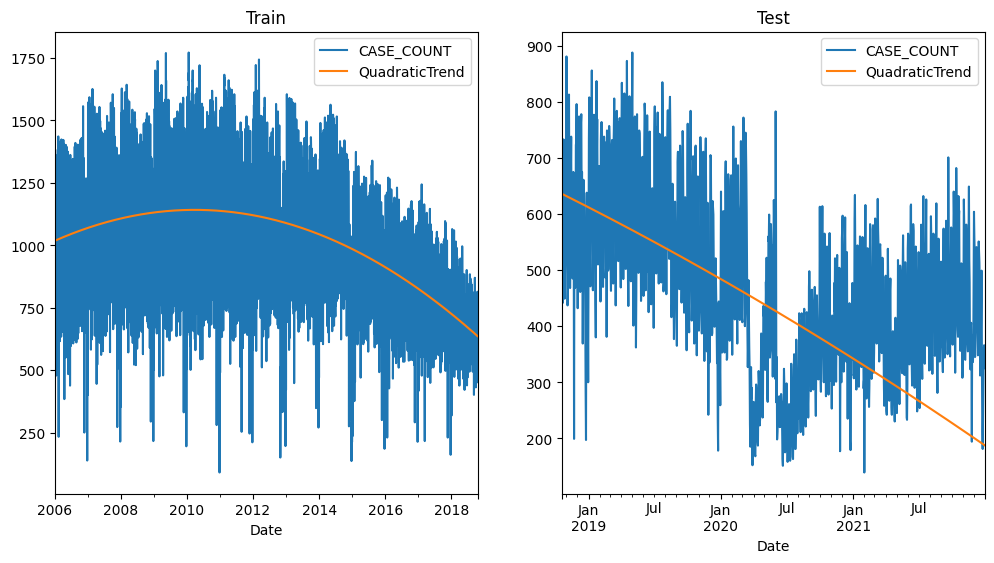

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
df_train.plot(kind="line", y = ["CASE_COUNT", "QuadraticTrend"], ax=axes[0], title='Train')
df_test.plot(kind="line", y = ["CASE_COUNT", "QuadraticTrend"], ax=axes[1], title='Test')
plt.show()

In [35]:
model_rmse = RMSE(df_test.QuadraticTrend, df_test.CASE_COUNT)

In [36]:
df_results.loc[3, "Model"] = "Quadratic Trend"
df_results.loc[3, "RMSE"] = model_rmse
df_results.head()

,Model,RMSE
0,Random Walk,244.370694
1,Mean,564.612685
2,Linear Trend,336.575295
3,Quadratic Trend,157.446619


In [37]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CASE_COUNT   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     631.7
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          1.47e-243
Time:                        13:36:39   Log-Likelihood:                -32752.
No. Observations:                4675   AIC:                         6.551e+04
Df Residuals:                    4672   BIC:                         6.553e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1018.1655     11.709     86.959      0.000     995.211    1041.120
timeIndex        0.1600      0.012     13.827      0.000       0.137       0.183
timeIndex_sq -5.171e-05    2.4e-06    -21.576      0.000   -5.64e-05    -4.7e-05
==============================================================================
Omnibus:                      159.108   Durbin-Watson:                   0.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.103
Skew:                          -0.443   Prob(JB):                     5.18e-37
Kurtosis:                       2.730   Cond. No.                     2.93e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Tendencia con Tranformacion Logaritmica

In [38]:
df_train['log_ventas'] = np.log(df_train.CASE_COUNT)
df_test['log_ventas'] = np.log(df_test.CASE_COUNT)

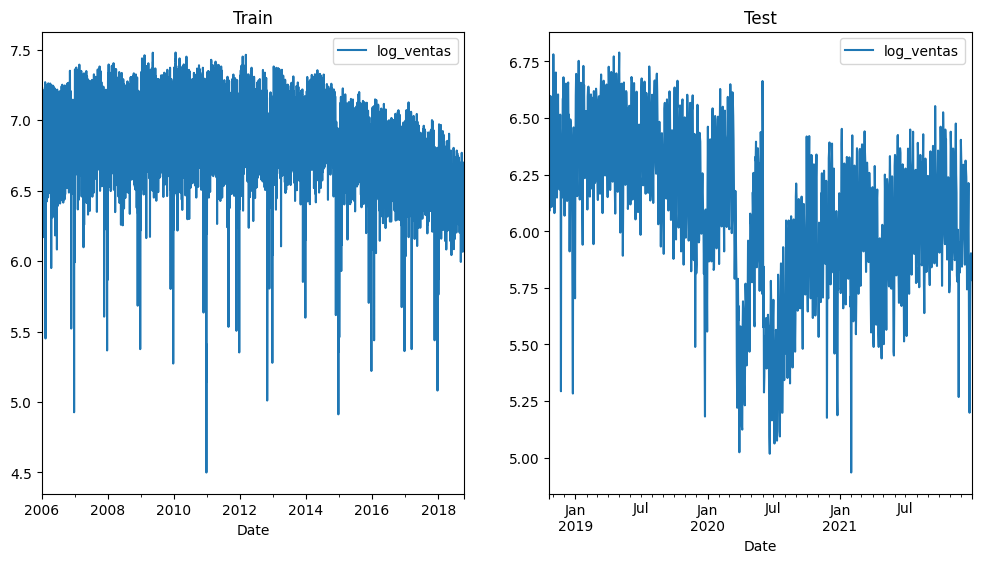

In [39]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
df_train.plot(kind="line", y = ["log_ventas"], ax=axes[0], title='Train')
df_test.plot(kind="line", y = ["log_ventas"], ax=axes[1], title='Test')
plt.show()

In [40]:
model_log = smf.ols(formula='log_ventas ~ timeIndex', data=df_train).fit()
df_train['LogTrend'] = model_log.predict(df_train[['timeIndex']])
df_test['LogTrend'] = model_log.predict(df_test[['timeIndex']])
df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

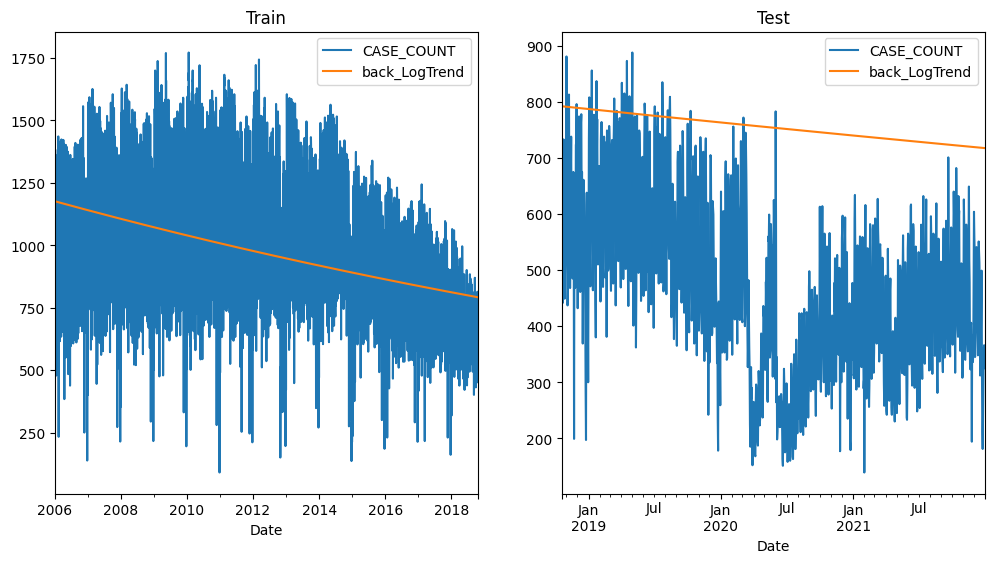

In [41]:
fig, axes = plt.subplots(1,2, figsize=(12,6))  
df_train.plot(kind="line", y = ["CASE_COUNT", "back_LogTrend"], ax=axes[0], title='Train')
df_test.plot(kind="line", y = ["CASE_COUNT", "back_LogTrend"], ax=axes[1], title='Test')
plt.show()

In [42]:
model_rmse = RMSE(df_test.back_LogTrend, df_test.CASE_COUNT)
df_results.loc[4, "Model"] = "back_LogTrend"
df_results.loc[4, "RMSE"] = model_rmse
df_results.head()

,Model,RMSE
0,Random Walk,244.370694
1,Mean,564.612685
2,Linear Trend,336.575295
3,Quadratic Trend,157.446619
4,back_LogTrend,317.401662


In [43]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_ventas   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     613.8
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          1.97e-127
Time:                        13:36:40   Log-Likelihood:                -1233.2
No. Observations:                4675   AIC:                             2470.
Df Residuals:                    4673   BIC:                             2483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0702      0.009    767.258      0.000       7.052       7.088
timeIndex   -8.46e-05   3.41e-06    -24.776      0.000   -9.13e-05   -7.79e-05
==============================================================================
Omnibus:                     1187.506   Durbin-Watson:                   0.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3902.129
Skew:                          -1.271   Prob(JB):                         0.00
Kurtosis:                       6.684   Cond. No.                     5.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Transformacion logaritmica + Estacionalidad Mensual

In [44]:
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month'] = [d.strftime('%b') for d in df_test.index]

In [45]:
dummies_mes_train = pd.get_dummies(df_train.month)
dummies_mes_test = pd.get_dummies(df_test.month)

In [46]:
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)
df_train.head()

,CASE_COUNT,timeIndex,timeIndex_sq,QuadraticTrend,log_ventas,LogTrend,back_LogTrend,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,,,,,,
2006-01-01,551,0,0,1018.165509,6.311735,7.070170,1176.348123,Jan,False,False,False,False,True,False,False,False,False,False,False,False
2006-01-02,618,1,1,1018.325440,6.426488,7.070086,1176.248609,Jan,False,False,False,False,True,False,False,False,False,False,False,False
2006-01-03,899,2,4,1018.485268,6.801283,7.070001,1176.149103,Jan,False,False,False,False,True,False,False,False,False,False,False,False
2006-01-04,1229,3,9,1018.644993,7.113956,7.069916,1176.049606,Jan,False,False,False,False,True,False,False,False,False,False,False,False
2006-01-05,1383,4,16,1018.804614,7.232010,7.069832,1175.950117,Jan,False,False,False,False,True,False,False,False,False,False,False,False


### prediction

In [47]:
model_log_est = smf.ols(formula='log_ventas ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep', data=df_train).fit()
df_train['model_log_est'] = model_log_est.predict(df_train[['timeIndex', "Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])
df_test['model_log_est'] = model_log_est.predict(df_test[['timeIndex', "Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

In [48]:
df_test

,CASE_COUNT,timeIndex,timeIndex_sq,QuadraticTrend,log_ventas,LogTrend,back_LogTrend,month,Apr,Aug,...,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-20,546,4675,21855625,635.846543,6.302619,6.674668,792.084053,Oct,False,False,...,False,False,False,False,False,False,False,True,False,6.706796
2018-10-21,441,4676,21864976,635.522949,6.089045,6.674583,792.017046,Oct,False,False,...,False,False,False,False,False,False,False,True,False,6.706712
2018-10-22,608,4677,21874329,635.199252,6.410175,6.674498,791.950044,Oct,False,False,...,False,False,False,False,False,False,False,True,False,6.706628
2018-10-23,682,4678,21883684,634.875451,6.525030,6.674414,791.883049,Oct,False,False,...,False,False,False,False,False,False,False,True,False,6.706544
2018-10-24,733,4679,21893041,634.551547,6.597146,6.674329,791.816058,Oct,False,False,...,False,False,False,False,False,False,False,True,False,6.706460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,297,5839,34093921,189.176496,5.693732,6.576194,717.801962,Dec,False,False,...,False,False,False,False,False,False,False,False,False,6.357224
2021-12-28,358,5840,34105600,188.732512,5.880533,6.576109,717.741239,Dec,False,False,...,False,False,False,False,False,False,False,False,False,6.357140
2021-12-29,366,5841,34117281,188.288424,5.902633,6.576025,717.680521,Dec,False,False,...,False,False,False,False,False,False,False,False,False,6.357056


In [49]:
df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

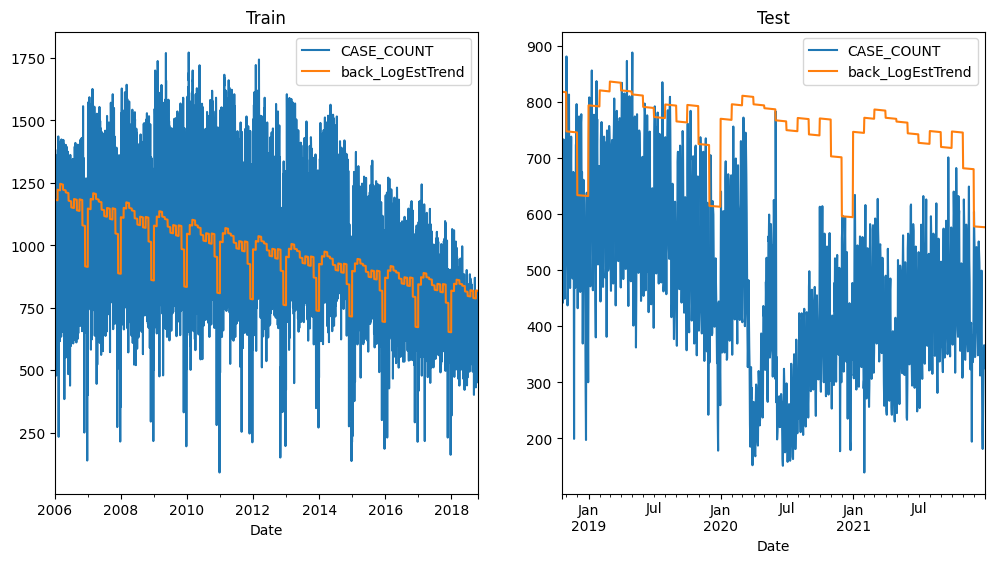

In [50]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
df_train.plot(kind="line", y = ["CASE_COUNT", "back_LogEstTrend"], ax=axes[0], title='Train')
df_test.plot(kind="line", y = ["CASE_COUNT", "back_LogEstTrend"], ax=axes[1], title='Test')
plt.show()

In [51]:
model_rmse = RMSE(df_test.back_LogEstTrend, df_test.CASE_COUNT)
df_results.loc[5, "Model"] = "back_LogEstTrend"
df_results.loc[5, "RMSE"] = model_rmse
df_results

,Model,RMSE
0,Random Walk,244.370694
1,Mean,564.612685
2,Linear Trend,336.575295
3,Quadratic Trend,157.446619
4,back_LogTrend,317.401662
5,back_LogEstTrend,318.614055


## Media Movil

In [52]:
df_dia['sma_5'] = df_dia.CASE_COUNT.rolling(5, min_periods=1).mean()
df_dia['sma_15'] = df_dia.CASE_COUNT.rolling(15, min_periods=1).mean()

<Axes: title={'center': 'SMA'}, xlabel='Date'>

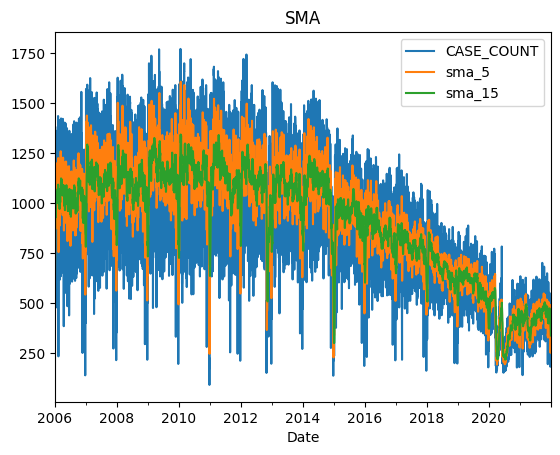

In [53]:
df_dia.plot(kind="line", y = ["CASE_COUNT", "sma_5", "sma_15"], title='SMA')

## Single Exponential Smoothing

In [54]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model_exp_smoothing_0 = SimpleExpSmoothing(df_train.CASE_COUNT).fit(smoothing_level=0, optimized=False)
model_exp_smoothing_03 = SimpleExpSmoothing(df_train.CASE_COUNT).fit(smoothing_level=0.3, optimized=False)
model_exp_smoothing_1 = SimpleExpSmoothing(df_train.CASE_COUNT).fit(smoothing_level=1, optimized=False)


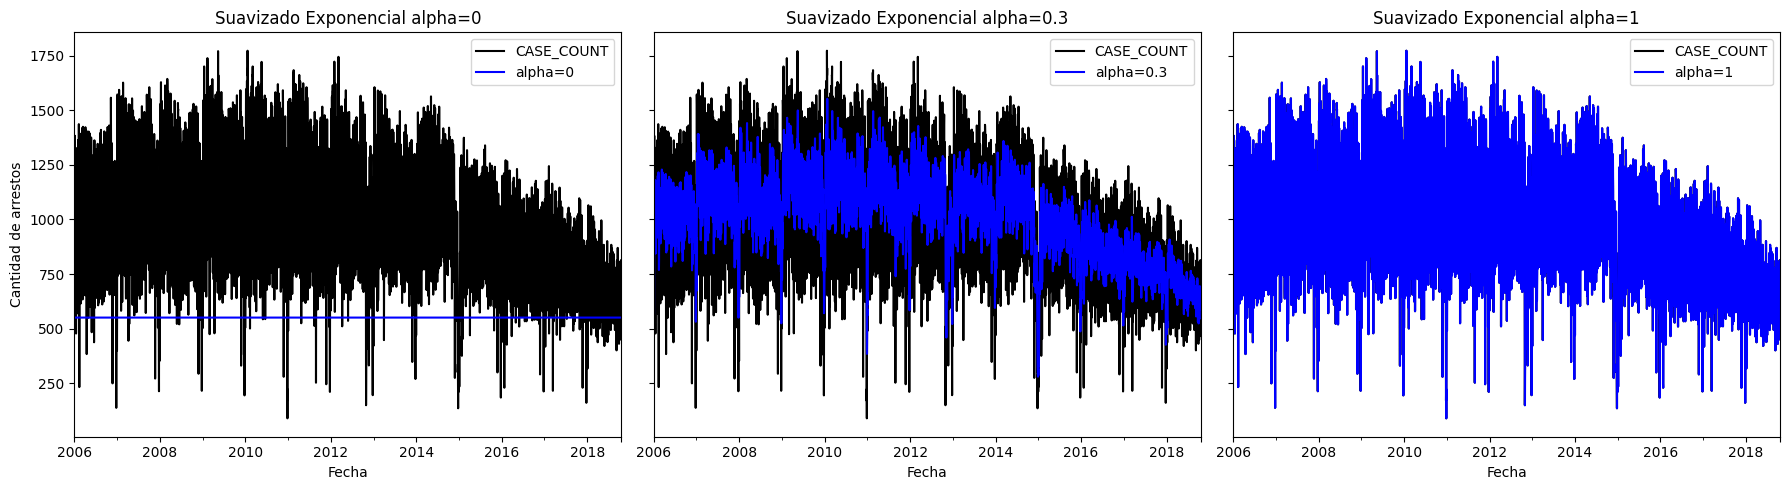

In [55]:
models = {
    "alpha=0": model_exp_smoothing_0,
    "alpha=0.3": model_exp_smoothing_03,
    "alpha=1": model_exp_smoothing_1,
}

# Graficar cada modelo en un gráfico separado
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)

for ax, (alpha, model) in zip(axes, models.items()):
    df_train.plot(kind="line", y="CASE_COUNT", color='black', ax=ax, title=f"Suavizado Exponencial {alpha}")
    model.fittedvalues.plot(ax=ax, label=alpha, color='blue')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Cantidad de arrestos')
    ax.legend()

plt.tight_layout()
plt.show()

In [56]:
df_test['simple_smoothing_0'] = model_exp_smoothing_0.forecast(len(df_test))
df_test['simple_smoothing_03'] = model_exp_smoothing_03.forecast(len(df_test))
df_test['simple_smoothing_1'] = model_exp_smoothing_1.forecast(len(df_test))

In [57]:
model_rmse_0 = RMSE(df_test.simple_smoothing_0, df_test.CASE_COUNT)
model_rmse_03 = RMSE(df_test.simple_smoothing_03, df_test.CASE_COUNT)
model_rmse_1 = RMSE(df_test.simple_smoothing_1, df_test.CASE_COUNT)
df_results.loc[6, "Model"] = "simple_smoothing_0"
df_results.loc[6, "RMSE"] = model_rmse_0
df_results.loc[7, "Model"] = "simple_smoothing_03"
df_results.loc[7, "RMSE"] = model_rmse_03
df_results.loc[8, "Model"] = "simple_smoothing_1"
df_results.loc[8, "RMSE"] = model_rmse_1
df_results

,Model,RMSE
0,Random Walk,244.370694
1,Mean,564.612685
2,Linear Trend,336.575295
3,Quadratic Trend,157.446619
4,back_LogTrend,317.401662
5,back_LogEstTrend,318.614055
6,simple_smoothing_0,174.34628
7,simple_smoothing_03,256.316308
8,simple_smoothing_1,244.370694


## Veamos Estacionalidad

In [58]:
series = df_dia['CASE_COUNT']

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series); 
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -1.809267
p-value: 0.375871
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


### p-value > 0.05 asi que la serie es no estacionaria

<Axes: xlabel='Date'>

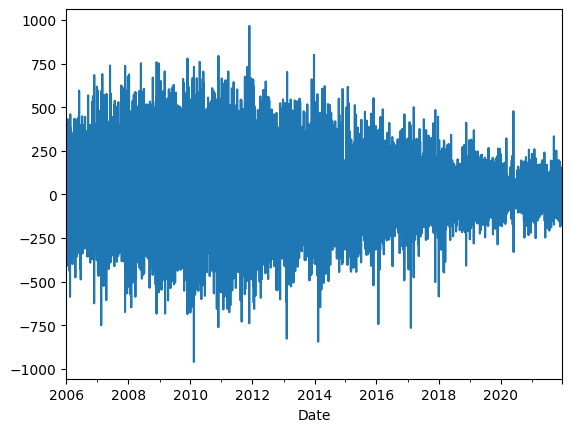

In [60]:
series.diff().plot()

In [61]:
result = adfuller(series.diff()[1:]); print('ADF Statistic: %f' % result[0]); 
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -19.541404
p-value: 0.000000
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


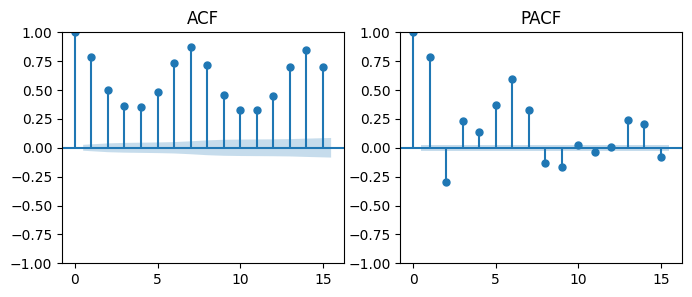

In [62]:
fig, axes = plt.subplots(1, 2,figsize=(8,3))
smt.graphics.plot_acf(series, lags=15,ax=axes[0],title='ACF')
smt.graphics.plot_pacf(series, lags=15,ax=axes[1],title='PACF')
plt.show()

## Modelos entrenados con datos semanales

### Resample semanalmente con la suma de casos diarios para simplificar el modelo y para correr las predicciones

In [63]:
df_sem = df_dia.resample('W').sum()

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt

df_train, df_test = train_test_split(
    df_sem, test_size=0.2, shuffle=False, random_state=42
)

# Convertir las columnas en series para trabajar con ARIMA
train = df_train['CASE_COUNT'].values
test = df_test['CASE_COUNT'].values

## Auto Arima para encontrar hiperparametros y entrenamos el modelo ARIMA

In [65]:
from pmdarima import auto_arima

auto_model = auto_arima(train, seasonal=True, m = 12, stepwise=True, trace=True, 
                        suppress_warnings=True, max_order=None, max_p=5, max_q=5, d=None, 
                        start_p=0, start_q=0)

params = auto_model.get_params()['order'] # Encontramos los mejores hiperparametros, encontrando los que minimizan AIC
seasonal_order = auto_model.get_params()['seasonal_order']

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=10869.149, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10867.963, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10838.470, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10795.202, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10865.999, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=10794.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=10795.514, Time=0.40 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=10795.431, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=10736.701, Time=0.20 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=10736.860, Time=0.63 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=10736.432, Time=0.79 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=10736.948, Time=0.94 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=10734.835, Time=2.02 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=10737.968, Time=2.36 sec
 ARIM

In [66]:
from statsmodels.tsa.arima.model import ARIMA
# Armamos modelo ARIMA
model_ARIMA = ARIMA(train, order=params, seasonal_order=seasonal_order)
results_ARIMA = model_ARIMA.fit()

# Resumen del modelo
print(results_ARIMA.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  668
Model:             ARIMA(1, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -5361.772
Date:                               Thu, 28 Nov 2024   AIC                          10733.545
Time:                                       13:37:07   BIC                          10756.059
Sample:                                            0   HQIC                         10742.267
                                               - 668                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4958      0.036     13.951      0.000       0.426       0.565
ma.L1      

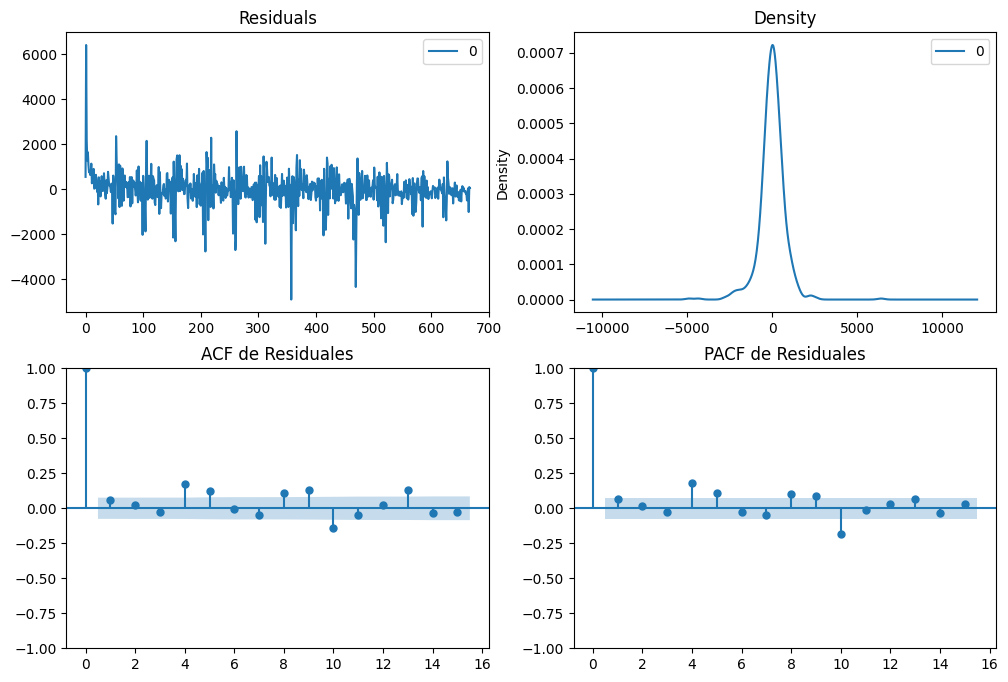

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Análisis de residuales
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
residuals.plot(title="Residuals", ax=axes[0, 0])
residuals.plot(kind='kde', title='Density', ax=axes[0, 1])
plot_acf(residuals, lags=15, ax=axes[1, 0], title='ACF de Residuales')
plot_pacf(residuals, lags=15, ax=axes[1, 1], title='PACF de Residuales')
plt.show()

#### Los picos de los residuos ACF y PACF se alejan de la franja azul, mostrando que puede haber autocorrelacion

## Quitar commentarios para las predicciones semanales 

In [68]:
# Entrenar y predecir usando una ventana deslizante
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=params)  # Usa el mismo orden que antes
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.3f}, expected={obs:.3f}')

predicted=4645.784, expected=4430.000
predicted=4566.547, expected=4338.000
predicted=4506.260, expected=4325.000
predicted=4488.900, expected=4250.000
predicted=4436.580, expected=4081.000
predicted=4329.354, expected=3665.000
predicted=4077.503, expected=4449.000
predicted=4498.463, expected=4635.000
predicted=4601.337, expected=4331.000
predicted=4430.421, expected=3916.000
predicted=4188.566, expected=3101.000
predicted=3707.511, expected=4165.000
predicted=4275.176, expected=4663.000
predicted=4551.770, expected=4599.000
predicted=4522.362, expected=4510.000
predicted=4476.562, expected=4181.000
predicted=4291.844, expected=4809.000
predicted=4641.167, expected=4424.000
predicted=4433.133, expected=4100.000
predicted=4249.483, expected=4309.000
predicted=4358.448, expected=4395.000
predicted=4404.160, expected=4660.000
predicted=4553.455, expected=4457.000
predicted=4445.039, expected=4431.000
predicted=4431.066, expected=4686.000
predicted=4575.056, expected=4632.000
predicted=45

Test RMSE: 396.655


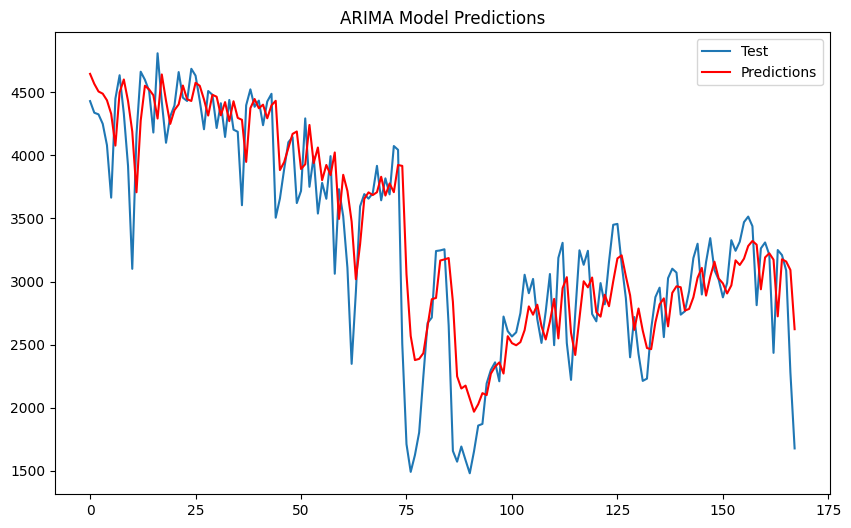

In [69]:
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(test, label='Test')
plt.plot(predictions, color='red', label='Predictions')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

In [70]:
# import pickle
# ## Guardamos modelo
# with open("./project/modelo_arima_semanal.pkl", "wb") as f:
#     pickle.dump(results_ARIMA, f)

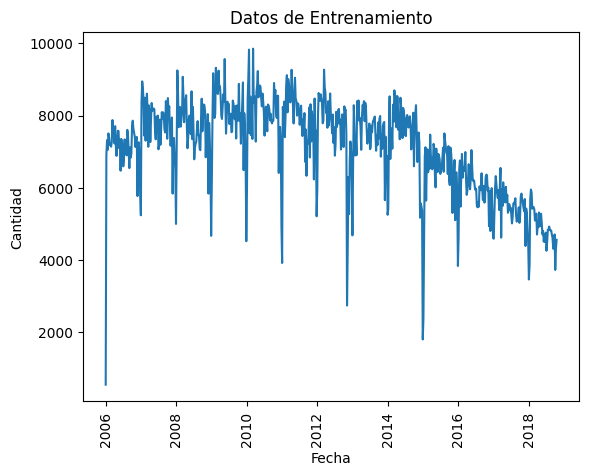

In [71]:
df_train = df_train.reset_index().rename(columns={'Date': 'ds', 'CASE_COUNT': 'y'})
df_test = df_test.reset_index().rename(columns={'Date': 'ds', 'CASE_COUNT': 'y'})

plt.plot(df_train['ds'], df_train['y'])
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.title('Datos de Entrenamiento')
plt.show()

## Modelo Prophet

In [72]:
from prophet import Prophet

model = Prophet()
model.fit(df_train)

13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:26 - cmdstanpy - INFO - Chain [1] done processing


### Guardamos modelo prophet con pickle en el archivo /project

In [73]:
import pickle
with open("./project/modelo_prophet_semanal.pkl", "wb") as f:
    pickle.dump(model, f)

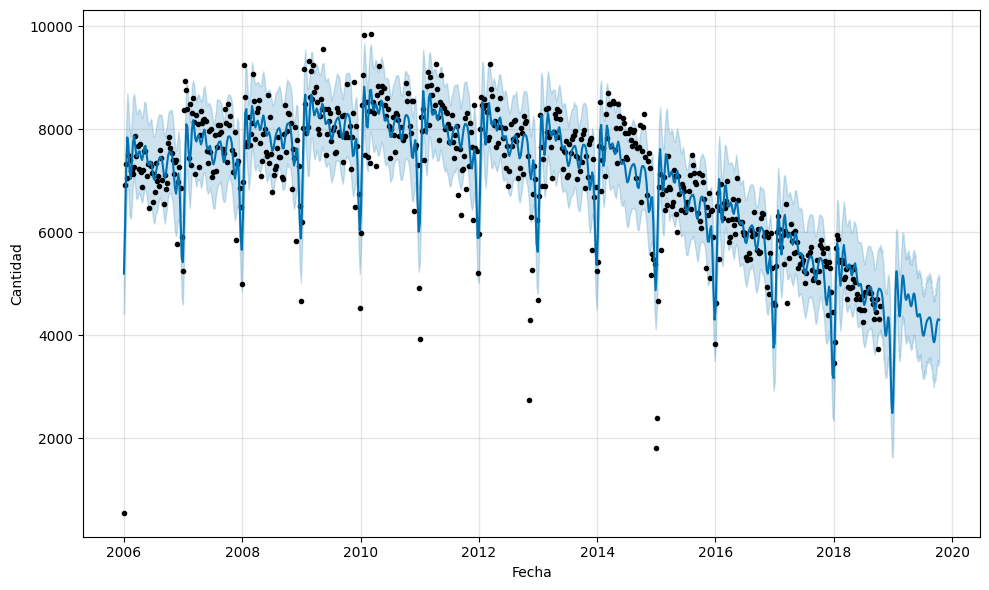

In [74]:
future = model.make_future_dataframe(periods=365)

# Hacer las predicciones
forecast = model.predict(future)

model.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.show()

In [75]:
forecast = model.predict(df_test)
rmse = sqrt(mean_squared_error(df_test['y'], forecast['yhat'][-len(df_test):]))
print(f'RMSE: {round(rmse,2)}')

RMSE: 857.7


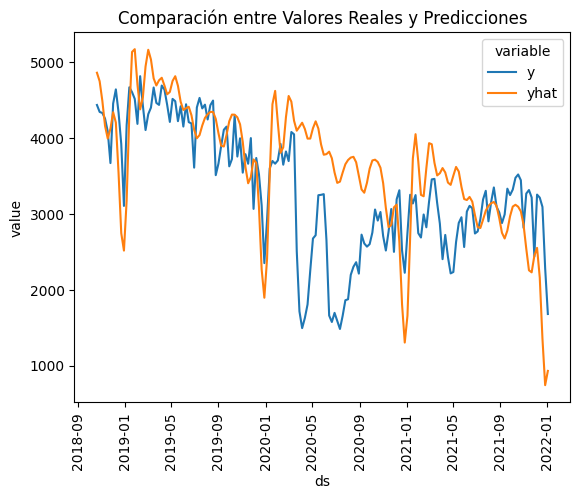

In [76]:
import seaborn as sns
aux = df_test.copy()
aux['yhat'] = forecast['yhat']
aux = pd.melt(aux, id_vars=['ds'], value_vars=['y', 'yhat'])

sns.lineplot(x=aux.ds, y=aux.value, hue=aux.variable)
plt.xticks(rotation=90)
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()

## Modelos entrenados con datos diarios

### ARIMA diario

In [77]:
from sklearn.metrics import mean_squared_error
from math import sqrt

df_train, df_test = train_test_split(
    df_dia, test_size=0.2, shuffle=False, random_state=42
)

# Convertir las columnas en series para trabajar con ARIMA
train = df_train['CASE_COUNT'].values
test = df_test['CASE_COUNT'].values

auto_model = auto_arima(train, seasonal=True, m = 12, stepwise=True, trace=True, 
                        suppress_warnings=True, max_order=None, max_p=5, max_q=5, d=None, 
                        start_p=0, start_q=0)

params = auto_model.get_params()['order'] # Encontramos los mejores hiperparametros, encontrando los que minimizan AIC
seasonal_order = auto_model.get_params()['seasonal_order']

model_ARIMA = ARIMA(train, order=params, seasonal_order=seasonal_order)
results_ARIMA = model_ARIMA.fit()

# Resumen del modelo
print(results_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=64258.673, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=65051.005, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=64517.574, Time=1.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=64208.504, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=65049.005, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=64797.273, Time=0.43 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=64206.898, Time=2.15 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=64418.759, Time=1.30 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=62892.564, Time=10.19 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=62891.981, Time=7.99 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=63810.625, Time=2.64 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=62444.803, Time=9.82 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=64380.353, Time=1.76 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=62446.268, Time=12.13 sec
 AR

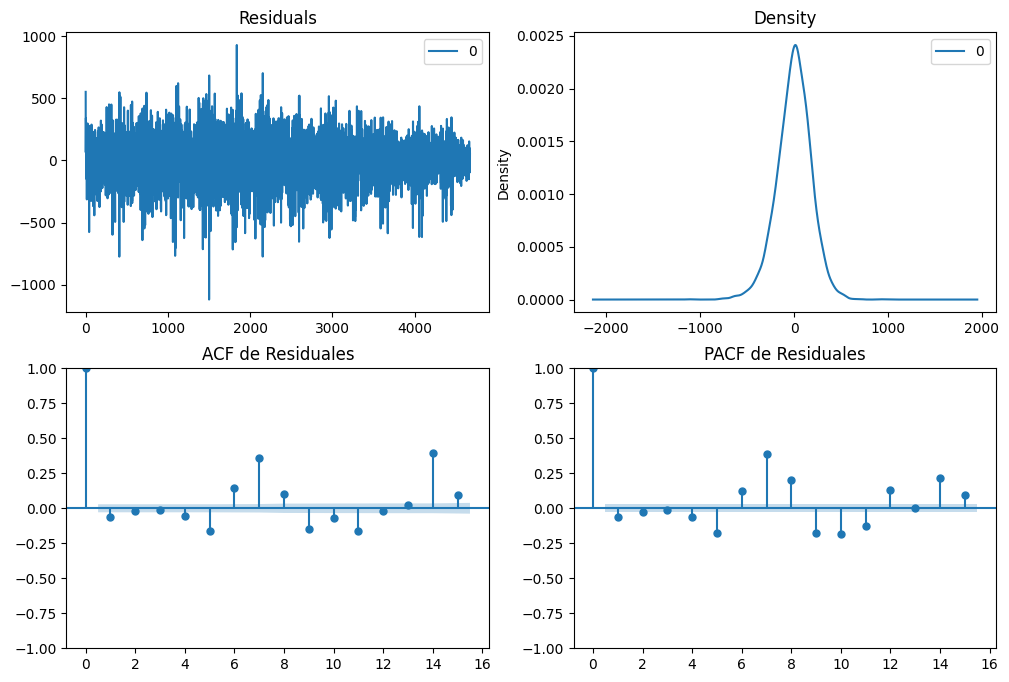

In [78]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
residuals.plot(title="Residuals", ax=axes[0, 0])
residuals.plot(kind='kde', title='Density', ax=axes[0, 1])
plot_acf(residuals, lags=15, ax=axes[1, 0], title='ACF de Residuales')
plot_pacf(residuals, lags=15, ax=axes[1, 1], title='PACF de Residuales')
plt.show()

### Prophet diario

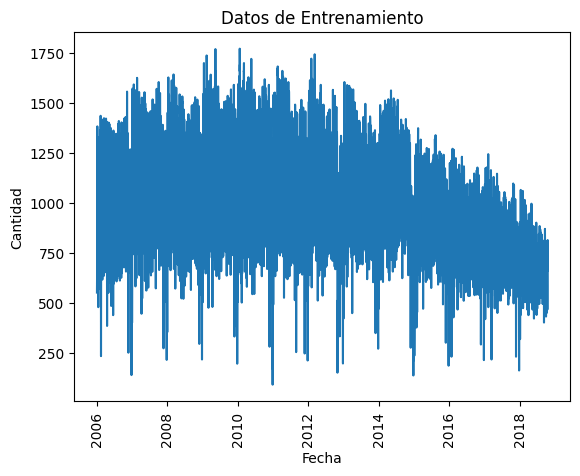

In [79]:
df_train = df_train.reset_index().rename(columns={'Date': 'ds', 'CASE_COUNT': 'y'})
df_test = df_test.reset_index().rename(columns={'Date': 'ds', 'CASE_COUNT': 'y'})

plt.plot(df_train['ds'], df_train['y'])
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.title('Datos de Entrenamiento')
plt.show()

In [80]:
from prophet import Prophet

model = Prophet()
model.fit(df_train)

13:44:30 - cmdstanpy - INFO - Chain [1] start processing
13:44:30 - cmdstanpy - INFO - Chain [1] done processing


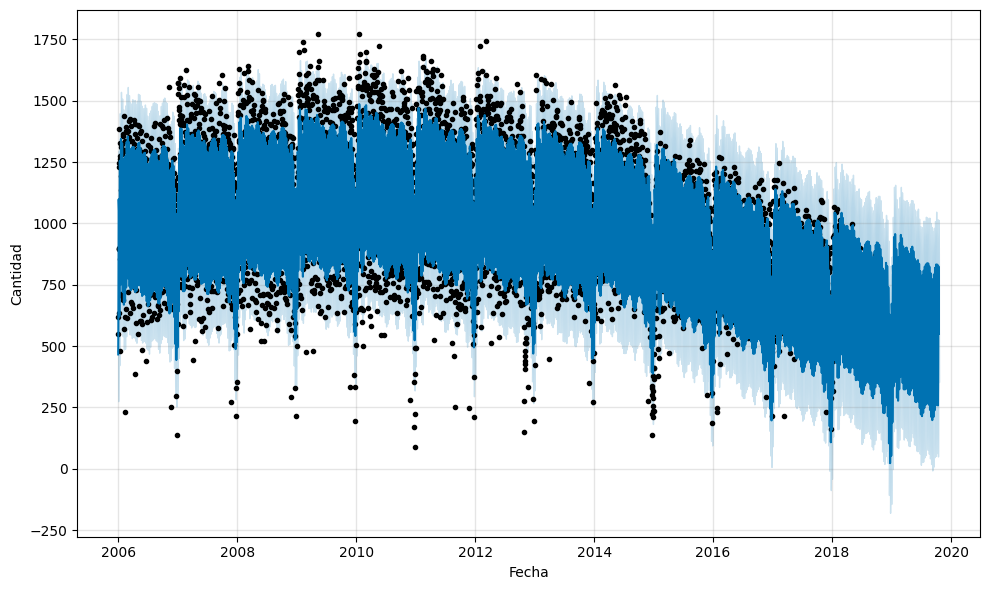

In [81]:
future = model.make_future_dataframe(periods=365)

# Hacer las predicciones
forecast = model.predict(future)

model.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.show()

In [82]:
forecast = model.predict(df_test)
rmse = sqrt(mean_squared_error(df_test['y'], forecast['yhat'][-len(df_test):]))
print(f'RMSE: {round(rmse,2)}')

RMSE: 188.63


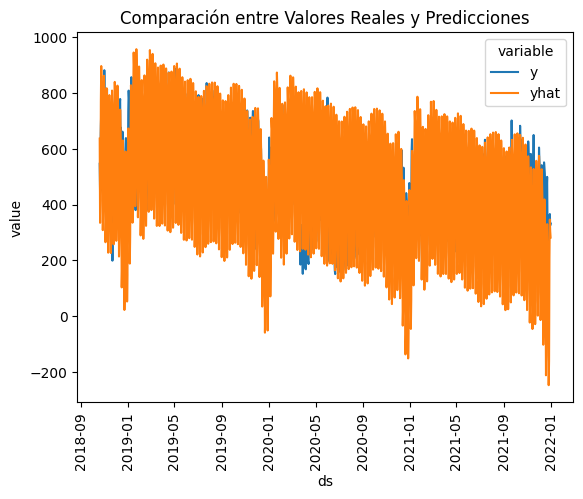

In [83]:
aux = df_test.copy()
aux['yhat'] = forecast['yhat']
aux = pd.melt(aux, id_vars=['ds'], value_vars=['y', 'yhat'])

sns.lineplot(x=aux.ds, y=aux.value, hue=aux.variable)
plt.xticks(rotation=90)
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()